## Asynchronous network analysis services

The Route service, the Closest Facility Service, and the Service Area Service support synchronous and asynchronous execution modes. Asynchronous and synchronous modes define how the application interacts with the service and gets the results.

* Synchronous execution mode: the application must wait for the request to finish and get the results. This execution mode is well-suited for requests that complete quickly (under 10 seconds).

* Asynchronouse execution mode: the client must periodically check whether the service has finished execution and, once completed, retrieve the results. While the service is executing, the application is available to do other things. This execution mode is well-suited for requests that take a long time to complete because it allows users to continue to interact with the application while the results are generated.

To submit synchronous calls to those services, you would need to access them via the `arcgis.network` module initializing the `NetworkLayer` objects for each type of the service.

To submit asynchronous calls to those services, you would need to access them via the `network.analysis` module.

Some services are in nature very compute intensive, so they can be accessed only via the asynchronous calls. These services are the Location-Allocation service, the Vehicle Routing Problem service, and the Origin Destination Cost Matrix Service.

## Route service

The route service can be used to find the best way to get from one location to another or to visit several locations. The best route can be the quickest route for a given time of day considering the traffic conditions applicable during that time, or it can be the shortest route that minimizes the travel distance. The route service can also find the best route that visits each stop during permitted time windows you specify. If you have more than two stops to visit, the best route can be determined for the fixed order of locations you specify. Such a route is called a simple route. Alternatively, the route service can determine the best sequence in which to visit the locations (the traveling salesperson problem). Such a route is called an optimized route.

> The maximum time an application can use the Route service when using the asynchronous execution mode is 1 hour (3,600 seconds). If your request does not complete within this time limit, it will time out and return a failure.

In [1]:
import datetime as dt
import pandas as pd
from arcgis.gis import GIS
import arcgis.geometry as geometry
import arcgis.network as network
import arcgis.features as features

pd.set_option("display.max_colwidth", 100)

user_name = "arcgis_python"
password = "P@ssword123"

my_gis = GIS("https://www.arcgis.com", user_name, password)

The  `find_routes` method's input parameters types are slightly different from the synchronous `solve` method of the `RouteLayer` network analysis layer. For instance, `time_of_day` optional parameter expects to get a `datetime` object and not the milliseconds since midnight, January 1 1970.

In [2]:
stops = features.FeatureSet.from_dict({
    "features": [{"attributes": {"Name": "Start point", "RouteName": "Route A"},
                  "geometry": {"x": -122.4079, "y": 37.78356}},
                 {"attributes": {"Name": "End point", "RouteName": "Route A"},
                  "geometry": {"x": -122.404, "y": 37.782}},
                 {"attributes": {"Name": "Start point", "RouteName": "Route B"},
                  "geometry": {"x": -122.4095, "y": 37.78379}},
                 {"attributes": {"Name": "End point", "RouteName": "Route B"},
                  "geometry": {"x": -122.48, "y": 37.734}}],    
    "spatialReference": {"wkid": 4326, "latestWkid": 4326},
    "geometryType": "esriGeometryPoint",
    "fields" : [
        {"name" : "Name", "type" : "esriFieldTypeString", "alias" : "Name", "length" : "50"},
        {"name" : "RouteName", "type" : "esriFieldTypeString", "alias" : "RouteName", "length" : "50"}
    ]
})

time_now = dt.datetime.now()
result = network.analysis.find_routes(stops, time_of_day=time_now)

When using synchronous network analysis services, you get back a Python dictionary with all the information you may need such as routes, stops, barriers, and directions. In contrast, when using asynchronous network analysis services, the result object returned is of `ToolOutput` type. This object has several properties associated with it.

#### Accessing output directions

In [3]:
df = result.output_directions.df
datetimes = pd.to_datetime(df["ArriveTime"] / 1000, unit="s")

df["ArriveTime"] = datetimes.apply(lambda x: x.strftime("%H:%M:%S"))
df[["RouteName", "ArriveTime", "DriveDistance", "ElapsedTime", "Text"]].loc[df["RouteName"] == "Route A"]

,RouteName,ArriveTime,DriveDistance,ElapsedTime,Text
0,Route A,14:00:00,0.000000,0.000000,Start at Start point
1,Route A,14:00:00,0.097817,0.853620,Go southeast on 5th St toward Stevenson St
2,Route A,14:00:51,0.172858,1.156560,Turn left on Mission St
3,Route A,14:02:00,0.121369,0.809119,Turn right on 4th St
4,Route A,14:02:49,0.109576,0.813873,Turn right on Howard St
5,Route A,14:03:37,0.000000,0.000000,"Finish at End point, on the left"


#### Accessing output routes

In [4]:
df = result.output_routes.df
start_times = pd.to_datetime(df["StartTime"], unit="ms")
end_times = pd.to_datetime(df["EndTime"], unit="ms")
df["StartTime"] = start_times.apply(lambda x: x.strftime("%H:%M:%S"))
df["EndTime"] = end_times.apply(lambda x: x.strftime("%H:%M:%S"))
df[["Name", "StartTime", "EndTime", "StopCount", "Total_Kilometers", "Total_Minutes"]]

,Name,StartTime,EndTime,StopCount,Total_Kilometers,Total_Minutes
0,Route A,14:00:00,14:03:37,2,0.807274,3.633172
1,Route B,14:00:00,14:25:12,2,13.605832,25.207284


#### Saving the output routes on a local disk

If you would need to take the result routes between stops into a desktop GIS for further analysis or visualization, you might want to save them into a shapefile. This can be done using `arcpy` package which comes together with the ArcGIS Desktop or ArcGIS Enterprise installation or by using the `save()` method of a `FeatureSet` object.

In [5]:
fc = result.output_routes.save(r"C:\Data", "outputRoutes_{}.shp".format(time_now.strftime("%H%M%S")))

## Service area service

With the service area service, you can find the area that can be reached from the input location within a given travel time or travel distance. A service area is the area that encompasses all streets that can be accessed within a given distance or travel time from one or more locations, referred to as facilities. Service areas are generally used to visualize and measure the accessibility of facilities. 

For example, a three-minute drive-time polygon around a grocery store can determine which residents are able to reach the store within three minutes and are thus more likely to shop there. The service can also create multiple concentric service areas around one or more facilities that can show how accessibility changes with an increase in travel time or travel distance. It can be used, for example, to determine how many hospitals are within 5, 10, and 15 minute drive times of schools. When creating service areas based on travel times, the service can make use of traffic data, which can influence the area that can be reached during different times of the day.

> The maximum time an application can use the service area service when using the asynchronous execution mode is 1 hour (3,600 seconds). If your request does not complete within that time limit, it will time out and return a failure.

In [6]:
input_coords = {"x": -13045715.158400763, "y": 4034297.869515602, "spatialReference": 3857}

facility = features.FeatureSet.from_dict({"geometryType": "esriGeometryPoint",
                                          "features": [{"geometry": input_coords}],
                                           "spatialReference": { "wkid": 102100, 
                                                                "latestWkid": 3857}})

time_now = datetime.datetime.now()
result = network.analysis.generate_service_areas(facilities=facility, break_values=30, 
                                                 break_units="Minutes", time_of_day=time_now)

#### Finding cities which are within the service area

After getting back the polygon representing the service area you can use the `geometry` module of `arcgis` package to filter features stored within a feature layer. If you have ArcGIS Pro, ArcGIS Desktop, or ArcGIS Server installed on the machine you author your Python script, you can use the `arcpy` site-package to re-project the Web Mercator coordinates into the WGS84 ones.

In [7]:
my_map = my_gis.map("Redlands, CA", zoomlevel=10)

![my_map](http://esri.github.io/arcgis-python-api/notebooks/nbimages/guide_na_using_async_servicearea_01.png)

<Item title:"USA Major Cities" type:Feature Layer Collection owner:esri>
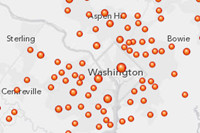

In [8]:
sample_cities = my_gis.content.search("title: 'USA Major Cities' type:Feature Service owner:esri", 
                                      outside_org=True)[0]
sample_cities

When submitting the query to a feature layer, it is possible to specify the `filter` object: this is the geometry to apply as the spatial filter. In this case, we want to select all point features (cities) in the feature layer that are located within the polygon feature (service area).

In [9]:
sa = result.service_areas.features[0]
fl = sample_cities.layers[0]

sa_filter = geometry.filters.contains(geometry.Polygon(sa.geometry), sr=4326)
filtered_cities = fl.query(geometry_filter=sa_filter, out_fields="Name", return_geometry=True, out_sr=4326)

In [10]:
my_map.clear_graphics()
my_map.draw(sa.geometry)
my_map.draw(input_coords)

city_symbol = {
"type": "esriSMS",
 "style": "esriSMSCircle ",
 "color": [0,0,0,255],
 "size": 4,
 "angle": 0,
 "xoffset": 0,
 "yoffset": 0,
 "outline": 
  {
  "color": [152,230,0,255],
   "width": 1
  }
}

for city in filtered_cities:
    my_map.draw(city.geometry, symbol=city_symbol)

Finally, it can be handy just to print out some of the attributes of the features that were returned by the query. The result representing the query's result feature set can be represented as a `pandas` data frame which makes it very easy to inspect or process data further.

In [11]:
print(filtered_cities.df.sort_values(by="NAME").NAME.values)

['Banning' 'Beaumont' 'Bloomington' 'Colton' 'Grand Terrace' 'Highland'
 'Loma Linda' 'Moreno Valley' 'Redlands' 'Rialto' 'Rubidoux'
 'San Bernardino' 'Yucaipa']


## Closest facility service

Finding the closest hospital to an accident, the closest police cars to a crime scene, and the closest store to a customer's address are all examples of problems that can be solved using the closest facility service. When finding the closest facilities, you can specify how many to find and whether the direction of travel is toward or away from them. Once you've found the closest facilities, you can display the best route to or from them and include the travel time, travel distance, and driving directions to each facility. The service can use current traffic conditions when determining the best routes. Additionally, you can specify an impedance cutoff beyond which the service should not search for a facility. 

For instance, you can set up a closest facility service to search for hospitals within 15 minutes' drive time of the site of an accident. Any hospitals that take longer than 15 minutes to reach will not be included in the results. The hospitals are referred to as facilities, and the accident is referred to as an incident. The service allows you to perform multiple closest facility analyses simultaneously. This means you can have multiple incidents and find the closest facility or facilities to each incident.

> The maximum time an application can use the closest facility service when using the asynchronous execution mode is 1 hour (3,600 seconds). If your request does not complete within this time limit, it will time out and return a failure.

In [12]:
incidents = features.FeatureSet.from_dict({
    "features": [{"attributes": {"CurbApproach": 0,
                                 "ID": "C100045",
                                 "Name": "Incident 1"},
                  "geometry": {"x": -0.1891, "y": 51.5251}},
                 {"attributes": {"CurbApproach": 0,
                                 "ID": "F100086",
                                 "Name": "Incident 2"},
                  "geometry": {"x": -0.1884, "y": 51.5353}}],
    "spatialReference": {"wkid": 4326, "latestWkid": 4326},
    "geometryType": "esriGeometryPoint",
    "fields" : [
        {"name" : "ID", "type" : "esriFieldTypeString", "alias" : "ID", "length" : "50"},
        {"name" : "Name", "type" : "esriFieldTypeString", "alias" : "Name", "length" : "50"},
        {"name" : "CurbApproach", "type" : "esriFieldTypeInteger", "alias" : "CurbApproach"}
    ]})

In [13]:
facilities = features.FeatureSet.from_dict({
    "features": [{"attributes": {"CurbApproach": 0,
                                 "ID": "F100045",
                                 "Name": "Facility 1"},
                  "geometry": {"x": -0.1892, "y": 51.5252}},
                 {"attributes": {"CurbApproach": 0,
                                 "ID": "F100086",
                                 "Name": "Facility 2"},
                  "geometry": {"x": -0.1879, "y": 51.5256}}],
    "spatialReference": {"wkid": 4326, "latestWkid": 4326},
    "geometryType": "esriGeometryPoint",
    "fields": [
        {"name" : "ID", "type" : "esriFieldTypeString", "alias" : "ID", "length" : "50"},
        {"name" : "Name", "type" : "esriFieldTypeString", "alias" : "Name", "length" : "50"},
        {"name" : "CurbApproach", "type" : "esriFieldTypeInteger", "alias" : "CurbApproach"}
    ]})

In [14]:
time_now = dt.datetime.now()
result = network.analysis.find_closest_facilities(incidents=incidents, facilities=facilities, 
                                                  cutoff=30, time_of_day=time_now, 
                                                  number_of_facilities_to_find=2)

Just as with result objects received from the route and service area services, it is very easy to get the information needed by iterating the `pandas` data frame of the solved routes feature set.

In [15]:
df = result.output_routes.df
start_times = pd.to_datetime(df["StartTime"], unit="ms")
end_times = pd.to_datetime(df["EndTime"], unit="ms")
df["StartTime"] = start_times.apply(lambda x: x.strftime("%H:%M:%S"))
df["EndTime"] = end_times.apply(lambda x: x.strftime("%H:%M:%S"))
df[["Name", "StartTime", "EndTime", "FacilityID", "Total_Kilometers", "Total_Minutes"]]

,Name,StartTime,EndTime,FacilityID,Total_Kilometers,Total_Minutes
0,Incident 1 - Facility 2,14:00:00,14:00:12,F100086,0.100538,0.211403
1,Incident 1 - Facility 1,14:00:00,14:00:37,F100045,0.224547,0.631271
2,Incident 2 - Facility 2,14:00:00,14:03:32,F100086,1.632258,3.538807
3,Incident 2 - Facility 1,14:00:00,14:03:53,F100045,1.731362,3.891970


## Origin Destination Cost Matrix Service

The Origin Destination Cost Matrix service helps you to create an origin-destination (OD) cost matrix from multiple origins to multiple destinations. An OD cost matrix is a table that contains the cost, such as the travel time or travel distance, from each origin to each destination. Additionally, it ranks the destinations that each origin connects to in ascending order based on the minimum cost required to travel from that origin to each destination. When generating an OD cost matrix, you can optionally specify the maximum number of destinations to find for each origin and the maximum time or distance to travel when searching for destinations.

> The maximum time an application can use the Origin Destination Cost Matrix service is 1 hour (3,600 seconds). If your request does not complete within this time limit, it will time out and return a failure.

In [16]:
origins = features.FeatureSet.from_dict({
    "features": [{"attributes": {"Name": "Origin 1"},
                  "geometry": {"x": -0.1891, "y": 51.5254}},
                 {"attributes": {"Name": "Origin 2"},
                  "geometry": {"x": -0.1744, "y": 51.5353}}],
    "spatialReference": {"wkid": 4326, "latestWkid": 4326},
    "geometryType": "esriGeometryPoint",
    "fields": [
        {"name": "Name", "type": "esriFieldTypeString", "alias": "Name", "length": "50"}        
    ]})

destinations = features.FeatureSet.from_dict({
    "features": [{"attributes": {"CurbApproach": 0, 
                                 "Name": "Destination 1"},
                  "geometry": {"x": -0.1991, "y": 51.5354}},
                 {"attributes": {"CurbApproach": 0, 
                                 "Name": "Destination 2"},
                  "geometry": {"x": -0.1844, "y": 51.5458}}],
    "spatialReference": {"wkid": 4326, "latestWkid": 4326},
    "geometryType": "esriGeometryPoint",
    "fields": [
        {"name": "Name", "type": "esriFieldTypeString", "alias": "Name", "length": "50"},
        {"name" : "CurbApproach", "type" : "esriFieldTypeInteger", "alias" : "CurbApproach"}
    ]})

time_now = dt.datetime.now()
result = network.analysis.generate_origin_destination_cost_matrix(origins=origins, destinations=destinations,
                                                                  time_of_day=time_now, cutoff=200,
                                                                  number_of_destinations_to_find=10)

Just as with result objects received from the services earlier, it is very easy to get the information needed by iterating the `pandas` data frame of the lines connecting the origins and the destinations.

In [17]:
result.output_origin_destination_lines.df[["OriginName", "DestinationName", 
                                           "Total_Distance", "Total_Time"]]

,OriginName,DestinationName,Total_Distance,Total_Time
0,Origin 1,Destination 1,2.257344,7.089845
1,Origin 1,Destination 2,3.597443,10.357463
2,Origin 2,Destination 2,1.929446,5.898859
3,Origin 2,Destination 1,2.314819,7.024884


## Location-Allocation service

Location-allocation helps you choose which facilities from a set of facilities to operate based on their potential interaction with demand points. The objective may be to minimize the overall distance between demand points and facilities, maximize the number of demand points covered within a certain distance of facilities, maximize an apportioned amount of demand that decays with increasing distance from a facility, or maximize the amount of demand captured in an environment of friendly and competing facilities.

> The maximum time an application can use the location-allocation service is 1 hour (3,600 seconds). If your request does not complete within this time limit, it will time out and return a failure.

In [18]:
facilities = features.FeatureSet.from_dict({
    "features": [{"attributes": {"Capacity": 100,
                                 "CurbApproach": 0,
                                 "ID": "F100045",
                                 "Name": "Facility 1"},
                  "geometry": {"x": -0.1891, "y": 51.5254}},
                 {"attributes": {"Capacity": 150,
                                 "CurbApproach": 0,
                                 "ID": "F100086",
                                 "Name": "Facility 2"},
                  "geometry": {"x": -0.1744, "y": 51.5353}}],
    "spatialReference": {"wkid": 4326, "latestWkid": 4326},
    "geometryType": "esriGeometryPoint",
    "fields": [
        {"name" : "ID", "type" : "esriFieldTypeString", "alias" : "ID", "length" : "50"},
        {"name" : "Name", "type" : "esriFieldTypeString", "alias" : "Name", "length" : "50"},
        {"name" : "CurbApproach", "type" : "esriFieldTypeInteger", "alias" : "CurbApproach"},
        {"name" : "Capacity", "type" : "esriFieldTypeInteger", "alias" : "Capacity"}
    ]
})

demand_points = features.FeatureSet.from_dict({
    "features": [{"attributes": {"CurbApproach": 0,
                                 "ID": "C00001",
                                 "Name": "Customer 1",
                                 "Weight": 10},
                  "geometry": {"x": -0.1891, "y": 51.5354}},
                 {"attributes": {"CurbApproach": 1,
                                 "ID": "C00002",
                                 "Name": "Customer 2",
                                 "Weight": 7},
                  "geometry": {"x": -0.1744, "y": 51.5453}}],
    "spatialReference": {"wkid": 4326, "latestWkid": 4326},
    "geometryType": "esriGeometryPoint",
    "fields": [
        {"name" : "ID", "type" : "esriFieldTypeString", "alias" : "ID", "length" : "50"},
        {"name" : "Name", "type" : "esriFieldTypeString", "alias" : "Name", "length" : "50"},
        {"name" : "CurbApproach", "type" : "esriFieldTypeInteger", "alias" : "CurbApproach"},
        {"name" : "Weight", "type" : "esriFieldTypeInteger", "alias" : "Weight"}
    ]
})

time_now = dt.datetime.now()
result = network.analysis.solve_location_allocation(facilities=facilities, demand_points=demand_points, 
                                                    number_of_facilities_to_find=1, 
                                                    default_measurement_cutoff=200,
                                                    time_of_day=time_now)

Just as with result objects received from the services earlier, it is very easy to get the information needed by iterating the `pandas` data frame of the solved solution.

In [19]:
result.output_allocation_lines.df[["Name", "Weight", "TotalWeighted_Minutes", 
                                   "Total_Kilometers", "Total_Minutes"]]

,Name,Weight,TotalWeighted_Minutes,Total_Kilometers,Total_Minutes
0,Facility 2 - Customer 1,10,38.180805,1.424783,3.818080
1,Facility 2 - Customer 2,7,31.176309,1.702496,4.453758


## Vehicle Routing Problem service

Various organizations service orders with a fleet of vehicles. For example, a large furniture store might use several trucks to deliver furniture to homes. A specialized grease recycling company might route trucks from a facility to pick up used grease from restaurants. A health department might schedule daily inspection visits for each of its health inspectors. The problem that is common to these examples is the vehicle routing problem (VRP). 

Each organization needs to determine which orders (homes, restaurants, or inspection sites) should be serviced by each route (truck or inspector) and in what sequence the orders should be visited. The primary goal is to best service the orders and minimize the overall operating cost for the fleet of vehicles. The VRP service can be used to determine solutions for such complex fleet management tasks. In addition, the service can solve more specific problems because numerous options are available, such as matching vehicle capacities with order quantities, providing a high level of customer service by honoring any time windows on orders, giving breaks to drivers, and pairing orders so they are serviced by the same route.

> The maximum time an application can use the vehicle routing problem service when using the asynchronous execution mode is 4 hours (14,400 seconds). If your request does not complete within the time limit, it will time out and return a failure. When using the synchronous execution mode, the request must complete within 60 seconds. If your request takes longer, the web server handling the request will time out and return the appropriate HTTP error code in the response.

In [20]:
orders = features.FeatureSet.from_dict({
    "features": [{"attributes": {"DeliveryQuantities": "2000 100",
                                 "Name": "Order 1"},
                  "geometry": {"x": -117.5254, "y": 34.111}},
                 {"attributes": {"DeliveryQuantities": "1500 75", 
                                 "Name": "Order 2"},
                  "geometry": {"x": -117.51, "y": 34.111}}],
    "spatialReference": {"wkid": 4326, "latestWkid": 4326},
    "geometryType": "esriGeometryPoint",
    "fields": [
        {"name" : "DeliveryQuantities", "type" : "esriFieldTypeString", "alias" : "DeliveryQuantities", "length" : "50"},
        {"name" : "Name", "type" : "esriFieldTypeString", "alias" : "Name", "length" : "50"}
    ]
})

depots = features.FeatureSet.from_dict({
    "features": [{"attributes": {"Name": "Depot1"},
                  "geometry": {"x": -117.52, "y": 34.117}},
                 {"attributes": {"Name": "Depot2"}, 
                  "geometry": {"x": -117.53, "y": 34.131}}],
    "spatialReference": {"wkid": 4326, "latestWkid": 4326},
    "geometryType": "esriGeometryPoint",
 "fields": [
        {"name" : "Name", "type" : "esriFieldTypeString", "alias" : "Name", "length" : "50"}
    ]
})

routes = features.FeatureSet.from_dict({
    "features": [{"attributes": {"Capacities": "40000 2000",
                                 "EndDepotName": "Depot1",
                                 "Name": "Truck1",
                                 "SpecialtyNames": "BucketTruck",
                                 "StartDepotName": "Depot1"}},
                 {"attributes": {"Capacities": "30000 2500",
                                 "EndDepotName": "Depot2",
                                 "Name": "Truck2",
                                 "SpecialtyNames": None,
                                 "StartDepotName": "Depot2"}}],
    "fields": [
        {"name" : "Name", "type" : "esriFieldTypeString", "alias" : "Name", "length" : "50"},
        {"name" : "Capacities", "type" : "esriFieldTypeString", "alias" : "Capacities", "length" : "50"},
        {"name" : "EndDepotName", "type" : "esriFieldTypeString", "alias" : "EndDepotName", "length" : "50"},
        {"name" : "StartDepotName", "type" : "esriFieldTypeString", "alias" : "StartDepotName", "length" : "50"},
        {"name" : "SpecialtyNames", "type" : "esriFieldTypeString", "alias" : "SpecialtyNames", "length" : "50"}
    ]
})

In [21]:
result = network.analysis.solve_vehicle_routing_problem(orders=orders, depots=depots, 
                                                        default_date=dt.datetime.now().date(), 
                                                        routes=routes, populate_route_lines=True,
                                                        populate_directions=True,
                                                        directions_language="es")

In this example, we have solved a VRP using two vehicles, two orders, and two depots. The directions have been generated in Spanish and the geometry of the output route was generated as well.

In [22]:
df = result.out_directions.df
datetimes = pd.to_datetime(df["ArriveTime"] / 1000, unit="s")

df["ArriveTime"] = datetimes.apply(lambda x: x.strftime("%H:%M:%S"))
df[["ArriveTime", "DriveDistance", "ElapsedTime", "Text"]]

,ArriveTime,DriveDistance,ElapsedTime,Text
0,08:00:00,0.000000,0.000000,Comience en Depot1
1,08:00:00,0.078904,0.257049,Avance oeste en Bungalow Way hacia Crawford Pl
2,08:00:15,0.035915,0.167712,Gire a la izquierda en Crawford Pl
3,08:00:25,0.133621,0.514048,Gire a la derecha en Candlewood Dr
4,08:00:56,0.193694,0.401954,Gire a la izquierda en Etiwanda Ave
5,08:01:20,0.646209,1.527491,Gire a la izquierda en Miller Ave
6,08:02:52,0.294504,0.687373,Gire a la derecha en W Liberty Pkwy
7,08:03:33,0.160004,0.515656,Gire a la izquierda en McKinley Dr
8,08:04:04,0.052234,0.149645,Gire a la izquierda en W Yosemite Loop Rd
9,08:04:13,0.062086,0.438825,Gire a la izquierda en Danser Ct y seguidamente gire a la izquierda en Huntington St


As it turns out, using two vehicles was not necessary and therefore we are not interested in showing the report for the vehicles which were not used.

In [23]:
df = result.out_routes.df
df[~df["OrderCount"].isnull()][["Name", "OrderCount", "RegularTimeCost", "TotalCost", 
                                "TotalDistance", "TotalTime", "TotalTravelTime"]]

,Name,OrderCount,RegularTimeCost,TotalCost,TotalDistance,TotalTime,TotalTravelTime
0,Truck1,2.0,14.156536,14.156536,4.135126,14.156536,14.156536
